# House Prices - Advanced Regression Techniques
#### **Hi all, i try to introduce how to use autoML tools for getting quit nice score in this code, and  make it easier to understand.**

#### **Hope you like it.**
#### **All comments are more than welcome.:)**

# Background
#### I learned  lots of excellent data preprocessing methods in this competition, such as [*Comprehensive data exploration with Python,etc...*], but here I'm trying to hand it over to autoML.
#### Let's check the performance of automl. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## load data
train_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
target = 'SalePrice'
task = 'regression'
reward_metric = 'rmse'


# Add new features for this data

#### I'm inspired by Vadim Titko,it's really a interesting idea.

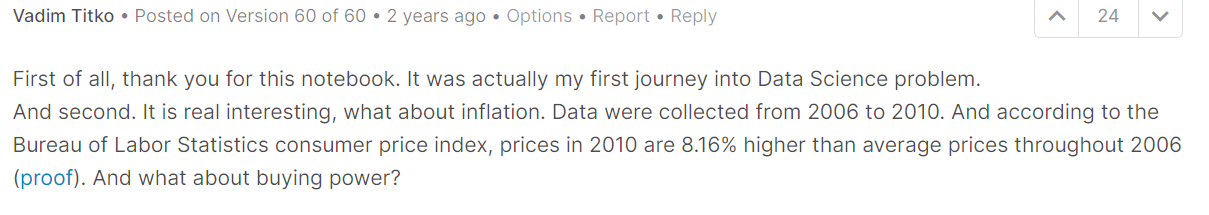
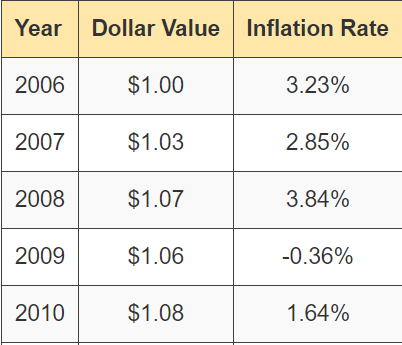

In [ ]:
train_data['dollor_value'] = train_data['YrSold'].apply(lambda k: [1.0,1.03,1.07,1.06,1.08][int(k)-2006])
test_data['dollor_value'] = test_data['YrSold'].apply(lambda k: [1.0,1.03,1.07,1.06,1.08][int(k)-2006])
train_data['inflation_rate'] = train_data['YrSold'].apply(lambda k: [0.0323,0.0285,0.0384,-0.0036,0.0164][int(k)-2006])
test_data['inflation_rate'] = test_data['YrSold'].apply(lambda k: [0.0323,0.0285,0.0384,-0.0036,0.0164][int(k)-2006])


train_data[target] = np.log1p(train_data[target])

In [ ]:
## install hypergbm
!pip3 install -U hypergbm
!pip3 install -U scikit-learn==0.23.2

# Learn some base info about hypergbm

In [ ]:
from hypergbm import make_experiment
from hypernets.core.trial import TrialHistory
from hypernets.searchers import PlaybackSearcher
from hypergbm.search_space import GeneralSearchSpaceGenerator
from hypernets.searchers import EvolutionSearcher
from hypernets.experiment.cfg import ExperimentCfg as cfg
cfg.experiment_discriminator=None

#### By printing estimator, we can see that estimator is a pipeline, including over three steps of data preprocessing, single model trainning and ensemble. The work flow is shown as below:
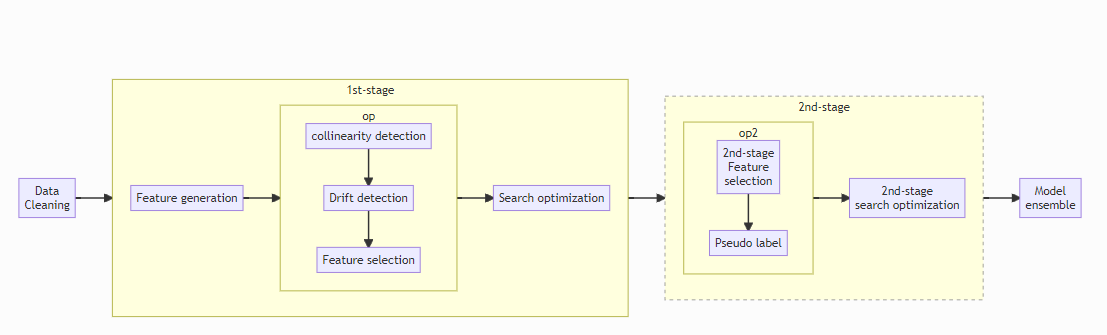
#### u can visit https://github.com/DataCanvasIO/HyperGBM for more details.

In [ ]:
experiment = make_experiment(train_data.copy(), target=target, reward_metric=reward_metric,max_trials=1,callbacks=[], search_callbacks=[])
estimator = experiment.run()
estimator

# Check the correlation between local score and PLB

Sometimes the local score gets better but the PLB gets worse, which we call overfitting, and sometimes you'll find Lightgbm and XGBoost have similar local scores but the PLB scores are very different. So I think it's very important to make sure that the local score and PLB are aligned before doing HPO.

### Example

In [ ]:
##difine search_space,only use lightgbm
search_space_ = GeneralSearchSpaceGenerator(n_estimators=2000,enable_xgb = False,enable_catboost=False) 
## define search_algorithm
rs = EvolutionSearcher(search_space_,optimize_direction='min',population_size=50, sample_size=6, candidates_size=5) 

##run make_experiment
exp = make_experiment(
                      train_data.copy(),
                      target=target,
                      num_folds= 5, ## 5 folds for Cross-validate
                      max_trials= 3, ## search for 10 trials
                      searcher = rs,
                      random_state=7,
                      callbacks=[], search_callbacks=[] #only for removing the trainning info, idea from issue#51
                      )
estimator = exp.run()

 We can choose trial_1(0.1256) and trial_1(0.1375) to submit.
 
 For checking that *cv_score up,PLB up?*  *the diff between cv_score and PLB*.
 
 U can do same things with catboost,xgboost(skip here)
 
 The result is as below:
 
 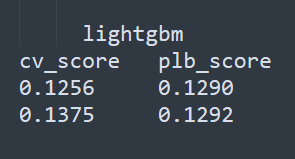
 
### Conclusion
* **Single model performance: catboost > lightgbm > xgboost**
* **It's hard to break 0.14 for xgboost**
* **Catboost cv_score have the highest similarity to PLB.**
* **Lightgbm's cv_score changed from 0.124 to 0.122, but the PLB remained the same.**


 
 

In [ ]:
search_history = exp.hyper_model_.history
for trial in search_history.trials:
    print(trial.trial_no,trial.reward)

# Ensemble one model with different random_state.

I  search best catboost model for 200 trials locally, and choose the best one.

I copy it 5 times, and try to reload them to ensemble.


PS: In hypergbm, same trial will skip to train, so i change the method of Scaler.

So that i could make 5 trials with different random_state, u can try it locally.

random_state is random,result maybe a little different with me.

**Using this way, i improve my score from 0.1218 to 0.1197**，


In [ ]:
# ## how to search and save history in hypergbm
# history = 'history.txt'
# search_space_ = GeneralSearchSpaceGenerator(n_estimators=2000,
#                                             enable_xgb = False,
#                                             enable_lightgbm=False,
#                                             catboost_init_kwargs={'random_state':8},
#                                             catboost_fit_kwargs = {'early_stopping_rounds':100}
#                                            ) 
# rs = EvolutionSearcher(search_space_,optimize_direction='min',population_size=50, sample_size=6, candidates_size=5) 

# exp = make_experiment(
#                       train_data.copy(),
#                       target=target,
#                       cv = True,
#                       num_folds= 5, 
#                       max_trials= 200, ## search for 200 trials
#                       early_stopping_time_limit= 7200,## search for 2h
#                       searcher = rs,
#                       random_state=7,
#                       callbacks=[], search_callbacks=[] #only for removing the trainning info, idea from issue#51
#                       )
# estimator = exp.run()
# exp.hyper_model_.history.save(history_file)

In [ ]:
##playback history
# history_file = f"/kaggle/input/resource/history_for_house_prices.txt"
history_file = f"/kaggle/input/resource/history_for_house_prices_v2.txt"
search_space_ = GeneralSearchSpaceGenerator(n_estimators=2000,
                                            enable_xgb = False,
                                            enable_lightgbm=False,
#                                             catboost_init_kwargs={'random_state':8}, ## cannot fix the random_state
                                            catboost_fit_kwargs = {'early_stopping_rounds':100}
                                           ) 
history = TrialHistory.load_history(search_space_, history_file)
playback = PlaybackSearcher(history, top_n=20, optimize_direction='min')

exp = make_experiment(
                      train_data = train_data.copy(),
                      target=target,
                      num_folds = 5,
                      max_trials=20,
                      searcher = playback,
                      callbacks=[], search_callbacks=[] #only for removing the trainning info, idea from issue#51
                      )
estimator = exp.run()


In [ ]:
search_history = exp.hyper_model_.history
for trial in search_history.trials:
    print(trial.trial_no,trial.reward)



In [ ]:
preds = estimator.predict(test_data)
preds = np.expm1(preds)
submission[target] = preds
submission.to_csv("submission.csv", index=False)
submission.head(5)

# Do a simple submit by hypergbm
we choose all GBM algorithm including lightgbm,xgboost,catboost, and search for 10 trials, and ensemble.

let's check the performance of this way.

In [ ]:
exp = make_experiment(
                      train_data.copy(),
                      target=target,
                      num_folds= 5, ## 5 folds for Cross-validate
                      max_trials= 10, ## search for 10 trials
                      random_state=7,
                      callbacks=[], search_callbacks=[] #only for removing the trainning info, idea from issue#51
                      )
estimator = exp.run()

In [ ]:
preds = estimator.predict(test_data)
preds = np.expm1(preds)
submission[target] = preds
submission.head(5)
# submission.to_csv("submission_PLB_0.12528.csv", index=False)

# Conclusion
* **Make sure the local score is aligned with the PLB before doing HPO**.
* **It's a good trying to ensemble the same models with different random_states**
* **You can get a baseline score with autoML tool.**
* **If you want to learn more, this is a good way to read the code of open source projects**  
* **Automl is a nice way to increase your interest in ML**